In [697]:
#%matplotlib inline
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

# UPDATE THE PATH BELOW TO THE CODE FOLDER

In [698]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

# Load stuff

In [1056]:
#These are the times (in units of the behaviour system bin running @1000Hz) at which spikes occurred

selected_session = 0

all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


#This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

#This is basically a big table (you can open it in excel) which contains
#relevant information about each time the animal poked one of the ports
task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

#
response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
#alternatively to change the time window


#not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
single_units = np.load(os.path.join(root_dir,'single_units.npy'))

In [1057]:
#np.unique(task_event_df['graph_type'])

In [1058]:
seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))

In [1059]:
graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
graph_type1 = task_event_df.loc[task_event_df['task_nr']==1]['graph_type'].values[0]
print(graph_type0,graph_type1)

loop loop


In [1060]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = n_states
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &    #task_nr was task
                                                (task_event_df['correct']==True) &    #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [1061]:
from scipy.optimize import minimize

def skew_sym_regress(X, X_dot, tol=1e-8):
    """
    Original data tensor is C x L x N where N is number of Neurons, L is length of each trial
    and C is number of conditions. We stack this to get L*C x N array.
    Args
    ----
    X_dot: First difference of (reduced dimension) data. Shape is T x N

    X: reduced dimension data. Shape is T x N
    """

    # 1) Initialize h using the odd part of the least-squares solution.
    # 2) call scipy.optimize.minimize and pass in our starting h, and x_dot, 
    T, N = X.shape
    M_lstq, _, _, _ = np.linalg.lstsq(X, X_dot, rcond=None)
    M_lstq = M_lstq.T
    M_init = 0.5 * (M_lstq - M_lstq.T)
    h_init = _reshape_mat2vec(M_init, N)

    options=dict(maxiter=10000, gtol=tol)
    result = minimize(lambda h: _objective(h, X, X_dot),
                    h_init,
                    jac=lambda h: _grad_f(h, X, X_dot),
                    method='CG',
                    options=options)
    if not result.success:
        print("Optimization failed.")
        print(result.message)
    M = _reshape_vec2mat(result.x, N)
    assert(np.allclose(M, -M.T))
    return M

In [1062]:

def _grad_f(h, X, X_dot):
    _, N = X.shape
    M = _reshape_vec2mat(h, N)
    dM = (X.T @ X @ M.T) - X.T @ X_dot
    return _reshape_mat2vec(dM.T - dM, N)


def _objective(h, X, X_dot):
    _, N = X.shape
    M = _reshape_vec2mat(h, N)
    return 0.5 * np.linalg.norm(X @ M.T - X_dot, ord='fro')**2


def _reshape_vec2mat(h, N):
    M = np.zeros((N, N))
    upper_tri_indices = np.triu_indices(N, k=1)
    M[upper_tri_indices] = h
    return M - M.T


def _reshape_mat2vec(M, N):
    upper_tri_indices = np.triu_indices(N, k=1)
    return M[upper_tri_indices]

In [1063]:
n_states = 9

In [1064]:
firing_rate_maps = get_task_responses(task_event_df,response_table)

In [1065]:
n_neurons, n_ports, n_tasks, n_directions = firing_rate_maps.shape

In [1066]:
spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))

In [1067]:
#here subtract the spatial terms
mds_frm = firing_rate_maps - spatial_map[:,:,None,None]

In [1068]:
mds_frm.shape

(135, 9, 2, 2)

In [1069]:
from sklearn.decomposition import PCA

In [1070]:
mds_frm_flat = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [1071]:
#when dealing with lines
#mds_frm_flat = np.hstack([mds_frm[:,seq0[1:-1],0,0],
#                          mds_frm[:,seq0[1:-1],0,1],
#                          mds_frm[:,seq1[1:-1],1,0],
#                          mds_frm[:,seq1[1:-1],1,1]])

In [1092]:
mds_frm_flat.shape

(135, 36)

In [1094]:
pca = PCA(n_components=12)

In [1095]:
pc_act = pca.fit_transform(mds_frm_flat.T)[:,:]

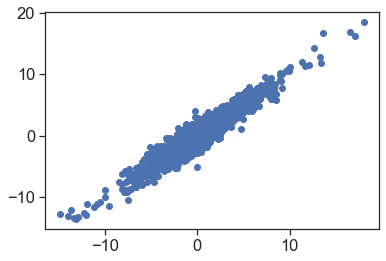

In [1096]:
plt.scatter(pca.inverse_transform(pc_act).flatten(),mds_frm_flat.T.flatten())

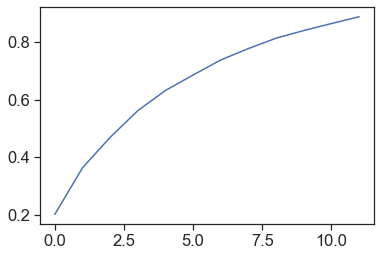

In [1097]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [1076]:
X_all = pc_act[:9]
X_alt_dir = pc_act[9:18]
X = pc_act[:9][1:]
Xval = pc_act[18:27]
Xval_alt_dir = pc_act[27:]

In [1077]:
Xdot = pc_act[:n_states][1:] - pc_act[:n_states][:-1]

In [1078]:
pc_act.shape

(36, 12)

In [1079]:
np.dot(M,X[0])

array([-2.22257016, -6.17669948,  2.80568322, -3.65367341, -0.45253497,
        2.13407713,  9.69751509,  4.10263134, 10.51310266,  7.79644717,
        1.66486981,  9.94224923])

In [1080]:
np.dot(X[0],M)

array([-3.2418896 ,  4.24837674, -0.71088706, -8.72485139,  2.95955406,
       -5.96914796,  3.04020683,  2.77728407,  0.51898026, -7.11840594,
        2.35422439,  1.00897394])

In [1081]:
X = pc_act[:n_states][:-1]

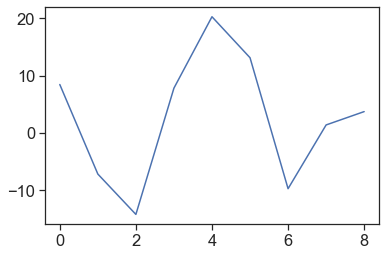

In [1082]:
plt.plot(pc_act[:9,0])

In [909]:
X = np.sin(np.linspace(0,12*np.pi,num=106).reshape(1,-1)*np.random.normal(size=(4))[:,None]).T + np.random.normal(size=4)
Xdot = np.diff(X,axis=0)


In [910]:
Xdot[0]

array([-0.32972966,  0.32989706, -0.39375187, -0.29116311])

In [911]:
Xdot.shape

(105, 4)

In [912]:
M = skew_sym_regress(X=X[:-1],X_dot=Xdot,)
assert np.all(M==-M.T) #definition of skew symmetric

In [738]:
M = skew_sym_regress(X=X_all[:-1],X_dot=X_all[1:])
assert np.all(M==-M.T) #definition of skew symmetric

Optimization failed.
Desired error not necessarily achieved due to precision loss.


In [913]:
M.shape

(4, 4)

In [1083]:
M = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(Xdot)
#print(M.shape)
#M = np.linalg.lstsq(X[1:],X[:-1],rcond=None)[0]

In [1084]:
M.dot(X[0])

array([ -5.87614801,  -4.55827874, -10.59623157,   2.77990425,
        -1.56790256,   9.87140336, -11.08345708,  16.83556844,
         7.74291556, -15.5479176 ,   2.93712207,   1.46320421])

In [1085]:
X[0]

array([ 8.44907723,  7.03214214,  9.47582578, -8.42935747, -7.00497837,
       -2.46483659, -0.49215985, -2.762561  , -7.30229024,  4.23349812,
       -2.74175333,  1.66539568])

In [1086]:
X[1]

array([-7.15575796, -3.71409734, 10.79736905, -7.4255548 ,  0.55488552,
       -0.61695131,  8.3719813 , -1.70075943,  1.53271153, -5.30825272,
        0.7132724 , -1.56514718])

In [1010]:
tmp =[X[0]]
for i in range(70):
    tmp.append(np.dot(M,tmp[-1]))
tmp = np.array(tmp)

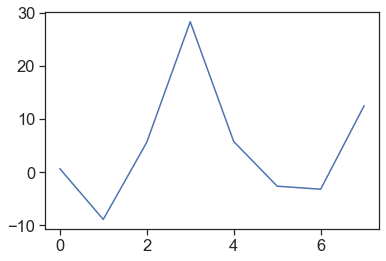

In [1011]:
plt.plot(X[:,0])

In [1012]:
X.shape

(8, 6)

In [1015]:
def fit_dynamics_matrix(X):
    Xdot = X[:n_states][1:] - X[:n_states][:-1]
    Xoffs = X[:-1]
    M = np.linalg.pinv(np.dot(Xoffs.T,Xoffs)).dot(Xoffs.T).dot(Xdot)
    return M
    

In [1090]:
M = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(Xdot)
print(M.shape)
#np.allclose(M,np.linalg.lstsq(X,Xdot,rcond=None)[0])

(12, 12)


In [1091]:
lamda, Q = np.linalg.eig(M)

In [1045]:
np.abs(lamda)

array([1.98786104e+00, 1.65098162e+00, 1.65098162e+00, 1.25581362e+00,
       1.25581362e+00, 8.39662158e-01, 8.39662158e-01, 1.76683219e-01,
       1.97583697e-16, 2.36603663e-16, 8.01565193e-17, 8.01565193e-17])

In [1046]:
lamda

array([ 1.98786104e+00+0.00000000e+00j,  1.55093031e+00+5.65999555e-01j,
        1.55093031e+00-5.65999555e-01j,  1.04381401e+00+6.98226444e-01j,
        1.04381401e+00-6.98226444e-01j,  3.31863980e-01+7.71296855e-01j,
        3.31863980e-01-7.71296855e-01j,  1.76683219e-01+0.00000000e+00j,
        1.97583697e-16+0.00000000e+00j, -2.36603663e-16+0.00000000e+00j,
       -6.32647070e-18+7.99064662e-17j, -6.32647070e-18-7.99064662e-17j])

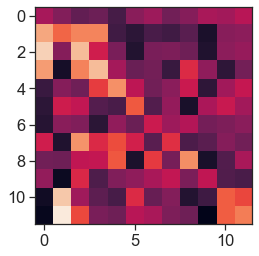

In [1047]:
plt.imshow(np.linalg.lstsq(X,Xdot,rcond=None)[0])

In [1048]:
def simulate_data(M):
    X = np.random.normal(size=(1,12))
    xs = [X]
    for _ in range(10):
        xs.append(np.dot(M,xs[-1])+xs[-1])

In [1049]:
xs = [np.random.normal(size=6)]
for _ in range(200):
    xs.append(np.dot(xs[-1],M)+xs[-1])

ValueError: shapes (6,) and (12,12) not aligned: 6 (dim 0) != 12 (dim 0)

In [1050]:
lamda, Q = np.linalg.eig(M)

In [1051]:
M2 = Q.dot(np.eye(len(Q))).dot(np.linalg.inv(Q))

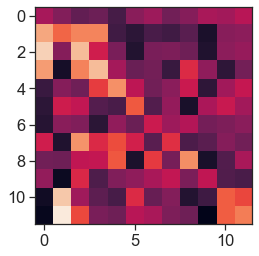

In [1052]:
plt.imshow(M)

In [1087]:
Xpred = []
for i in range(n_states-1):
    pred = np.dot(X[i],M) 
    Xpred.append(pred)

In [1088]:
Xpred = np.array(Xpred)

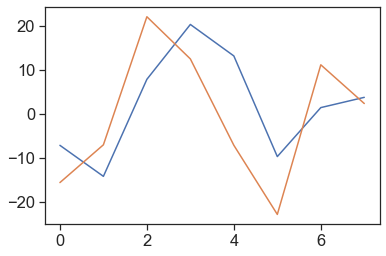

In [1089]:
dim = 0

plt.plot(X_all[1:,dim])
plt.plot(Xpred[:,dim])


In [467]:
all_neuron_pred = np.dot(Xpred,pca.components_)

In [468]:
all_neuron_pred = pca.inverse_transform(Xpred)

0.664036909499951


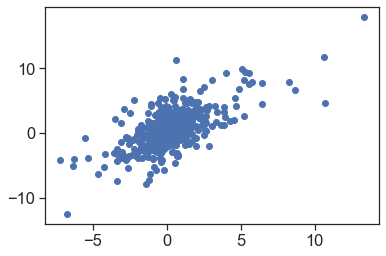

In [469]:
plt.scatter(all_neuron_pred.flatten(),mds_frm_flat[:,1:n_states].T.flatten())
cc = np.corrcoef(all_neuron_pred.flatten(),mds_frm_flat[:,1:n_states].T.flatten())[0,1]
print(cc)

# Now run in other direction 

In [666]:
Minv = np.linalg.pinv(M)

In [667]:
X_alt_dir = pc_act[n_states:2*n_states]
dset = X_alt_dir
Xpred = []
Xtar = []
for i in range(n_states-1,0,-1):
    pred = np.dot(dset[i],Minv) + dset[i]
    Xtar.append(dset[i])
    Xpred.append(pred)
Xpred = np.array(Xpred)
Xtar = np.array(Xtar)

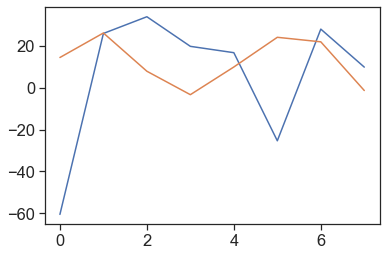

In [668]:
dim = 0
plt.plot(Xpred[:,dim])
plt.plot(Xtar[::-1,dim])

In [669]:
all_neuron_pred = pca.inverse_transform(Xpred)

0.20493951464146137


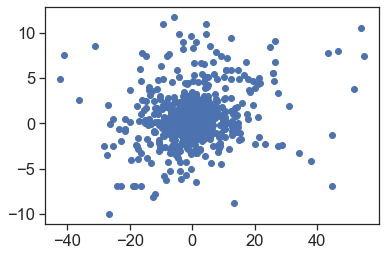

In [670]:
target = mds_frm_flat[:,n_states+1:2*n_states][:,::-1]
plt.scatter(all_neuron_pred.flatten(),target.T.flatten())
cc = np.corrcoef(all_neuron_pred.flatten(),target.T.flatten())[0,1]
print(cc)

# Now run on other dataset

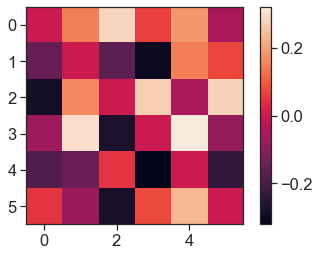

In [671]:
plt.imshow(M)
plt.colorbar()

In [672]:
np.dot(M,Xval[1]) + Xval[1]

array([ 8.68915389, 14.61467294, -5.53914199,  4.07486591, 18.89832298,
       -5.30814717])

In [673]:
Xval[1]

array([ 4.13405839, 11.38509792, -1.40252426, -5.71698294, 17.50033029,
       -8.73119238])

In [674]:
#Xval = pc_act[2*n_states:3*n_states]
dset = Xval
Xpred = []
Xtar = []
for i in range(8):
    pred = np.dot(dset[i],M) + dset[i]
    Xpred.append(pred)
    Xtar.append(dset[i+1])
Xpred = np.array(Xpred)
Xtar = np.array(Xtar)

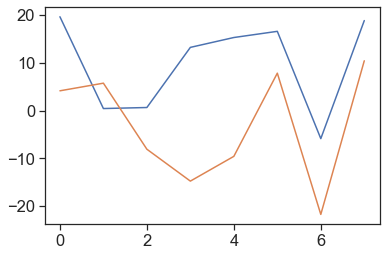

In [685]:
dim = 0
plt.plot(-Xpred[:,dim])
plt.plot(Xtar[:,dim])

In [686]:
all_neuron_pred = pca.inverse_transform(Xpred)

0.08773295516322192


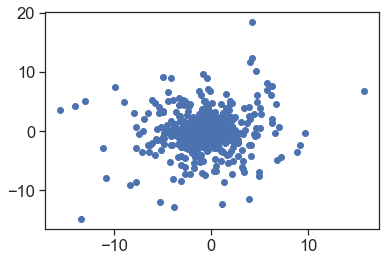

In [687]:
target = mds_frm_flat[:,19:27]
plt.scatter(all_neuron_pred.flatten(),target.T.flatten())
cc = np.corrcoef(all_neuron_pred.flatten(),target.T.flatten())[0,1]
print(cc)

# Other dataset in other direciton

In [688]:
Minv = np.linalg.pinv(M)

In [689]:
dset = Xval_alt_dir
Xpred = []
Xtar = []
for i in range(8,0,-1):
    pred = np.dot(dset[i],Minv) + dset[i]
    Xtar.append(dset[i-1])
    Xpred.append(pred)
Xpred = np.array(Xpred)
Xtar = np.array(Xtar)

In [694]:
all_neuron_pred = pca.inverse_transform(Xpred)

0.139714152788767


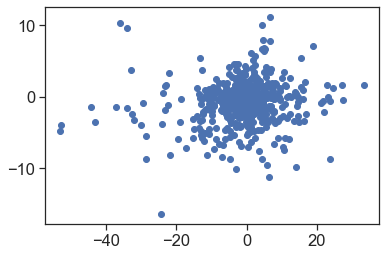

In [695]:
target = mds_frm_flat[:,3*n_states:-1][:,::-1]
plt.scatter(all_neuron_pred.flatten(),target.T.flatten())
cc = np.corrcoef(all_neuron_pred.flatten(),target.T.flatten())[0,1]

print(cc)

In [1098]:
import networkx as nx

In [1101]:
G1 = nx.cycle_graph(9)
G2 = nx.cycle_graph(9)

In [1107]:
G3 = nx.compose_all(G1,G2)

TypeError: compose_all() takes 1 positional argument but 2 were given

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


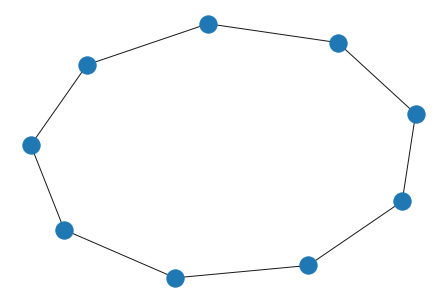

In [1106]:

nx.draw(G3)